## Imports

In [38]:
# Basic Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing Imports
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

### Helper Function to show the dataframe

In [39]:
def show_df_info(df, name="df"):
    print(f"---{name} shape:", df.shape)
    display(df.head(8))
    print("\nMissing per column:")
    print(df.isnull().sum())

## Create Synthetic Dataset

In [45]:
np.random.seed(42)
n = 30

age = np.random.randint(20,60,n).astype(float)
salary = np.random.randint(20000,200000,n).astype(float)
experience = np.random.randint(0,35,n).astype(float)
education = np.random.choice(['highschool','bachelor','master','phd'],size = n)
city = np.random.choice(['Mumbai','Bangalore','Kolkata','Delhi'],size = n)
owns_car = np.random.choice(['yes','no'],size=n)

# synthetic target based on salary & experience + noise
prob = (
    (salary / salary.max()) * 0.6
    + (experience / experience.max()) * 0.3
    + np.random.rand(n) * 0.1
)
target = (prob > 0.5).astype(int)

df = pd.DataFrame(
    {
        "age": age,
        "salary": salary,
        "experience_years": experience,
        "education_level": education,
        "city": city,
        "owns_car": owns_car,
        "target": target,
    }
)

df.head()

,age,salary,experience_years,education_level,city,owns_car,target
0,58.0,85725.0,3.0,phd,Delhi,no,0
1,48.0,149981.0,1.0,master,Bangalore,yes,1
2,34.0,104654.0,5.0,master,Kolkata,no,0
3,27.0,186845.0,3.0,master,Kolkata,no,1
4,40.0,139346.0,28.0,highschool,Mumbai,no,1


### Add Missing Values

In [46]:
# Introduce missing values intentionally
idx = np.random.choice(df.index, size=6, replace=False)
df.loc[idx[:2], "salary"] = np.nan
df.loc[idx[2:4], "experience_years"] = np.nan
df.loc[idx[4:], "owns_car"] = np.nan

show_df_info(df, "synthetic df")
print("\nTarget value counts:\n", df["target"].value_counts())

---synthetic df shape: (30, 7)


,age,salary,experience_years,education_level,city,owns_car,target
0,58.0,85725.0,3.0,phd,Delhi,no,0
1,48.0,149981.0,1.0,master,Bangalore,yes,1
2,34.0,104654.0,5.0,master,Kolkata,NaN,0
3,27.0,186845.0,3.0,master,Kolkata,no,1
4,40.0,139346.0,28.0,highschool,Mumbai,no,1
5,58.0,87435.0,17.0,phd,Kolkata,yes,0
6,38.0,76886.0,NaN,master,Mumbai,yes,0
7,42.0,86803.0,33.0,master,Kolkata,yes,1



Missing per column:
age                 0
salary              2
experience_years    2
education_level     0
city                0
owns_car            2
target              0
dtype: int64

Target value counts:
 target
1    16
0    14
Name: count, dtype: int64


## Train-Test Split

In [50]:
X = df.drop(columns=['target'])
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.25, random_state=42, stratify=y)

print("X_train: ",X_train.shape, "X_test: ", X_test.shape)

X_train:  (22, 6) X_test:  (8, 6)


# Scenario A

Create everything Manually ( No Column Transformer, No Pipeline )

In [51]:
numeric_cols = ['age','salary','experience_years']
ordinal_cols = ['education_level']
nominal_cols = ['city','owns_car']

### Simple Imputer

In [53]:
from sklearn.impute import SimpleImputer

num_imputer = SimpleImputer(strategy='median')

X_train_num = num_imputer.fit_transform(X_train[numeric_cols])
X_test_num = num_imputer.transform(X_test[numeric_cols])

X_train_num = pd.DataFrame(X_train_num, index=X_train.index, columns=numeric_cols)
X_test_num = pd.DataFrame(X_test_num, index=X_test.index, columns=numeric_cols)

### Standardization

In [58]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_num_scaled = scaler.fit_transform(X_train_num)
X_test_num_scaled = scaler.transform(X_test_num)

X_train_num_scaled = pd.DataFrame(X_train_num_scaled, index=X_train.index, columns=numeric_cols)
X_test_num_scaled = pd.DataFrame(X_test_num_scaled, index=X_test.index, columns = numeric_cols)

### Ordinal Encoding

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

oe = OrdinalEncoder(categories=[['highschool','bachelor','master','phd']])

X_train_ord = oe.fit_transform(X_train[ordinal_cols])
X_test_ord = oe.transform(X_test[ordinal_cols])

X_train_ord = pd.DataFrame(X_train_ord, index = X_train.index, columns=ordinal_cols)
X_test_ord = pd.DataFrame(X_test_ord,index=X_test.index, columns=ordinal_cols)

,education_level
13,1.0
22,3.0
25,1.0
2,2.0
16,2.0


### One Hot Encoder

In [65]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
X_train_nom = pd.DataFrame(ohe.fit_transform(X_train[nominal_cols]), index = X_train.index, columns = ohe.get_feature_names_out(nominal_cols))
X_test_nom = pd.DataFrame(ohe.transform(X_test[nominal_cols]), index = X_test.index, columns=ohe.get_feature_names_out(nominal_cols))

## Concatenate all the dataframes

In [66]:
X_train_manual = pd.concat([X_train_num_scaled,X_train_ord,X_train_nom],axis=1)
X_test_manual = pd.concat([X_test_num_scaled,X_test_ord,X_test_nom],axis=1)

In [68]:
print("Manual processed shapes:", X_train_manual.shape, X_test_manual.shape)
display(X_train_manual.head())

Manual processed shapes: (22, 9) (8, 9)


,age,salary,experience_years,education_level,city_Delhi,city_Kolkata,city_Mumbai,owns_car_yes,owns_car_nan
13,0.260781,-0.998170,-0.049825,1.0,0.0,1.0,0.0,0.0,1.0
22,1.093596,1.422973,0.049825,3.0,0.0,0.0,0.0,1.0,0.0
25,0.353316,-1.522209,-0.747372,1.0,0.0,1.0,0.0,1.0,0.0
2,-0.572035,-0.075405,-0.847021,2.0,0.0,1.0,0.0,0.0,1.0
16,-1.774990,-1.701562,0.149474,2.0,0.0,1.0,0.0,1.0,0.0


## Train and Evaluate the Model

In [69]:
from sklearn.linear_model import LogisticRegression

In [ ]:
model_manual = LogisticRegression(max_iter=1000)
model_manual.fit(X_train_manual, y_train)
y_pred_manual = model_manual.predict(X_test_manual)


array([0, 1, 1, 0, 0, 1, 0, 0])

In [75]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

print(accuracy_score(y_test, y_pred_manual))
print(confusion_matrix(y_test, y_pred_manual))
print(classification_report(y_test, y_pred_manual))

0.875
[[4 0]
 [1 3]]
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      0.75      0.86         4

    accuracy                           0.88         8
   macro avg       0.90      0.88      0.87         8
weighted avg       0.90      0.88      0.87         8



# Scenario B
Use ColumnTransformer (CT) but do not use Pipeline

In [78]:
np.random.seed(42)
n = 30

age = np.random.randint(20, 60, n).astype(float)
salary = np.random.randint(20000, 200000, n).astype(float)
experience = np.random.randint(0, 35, n).astype(float)
education = np.random.choice(["highschool", "bachelor", "master", "phd"], size=n)
city = np.random.choice(["Mumbai", "Bangalore", "Kolkata", "Delhi"], size=n)
owns_car = np.random.choice(["yes", "no"], size=n)

# synthetic target based on salary & experience + noise
prob = (
    (salary / salary.max()) * 0.6
    + (experience / experience.max()) * 0.3
    + np.random.rand(n) * 0.1
)
target = (prob > 0.5).astype(int)

df = pd.DataFrame(
    {
        "age": age,
        "salary": salary,
        "experience_years": experience,
        "education_level": education,
        "city": city,
        "owns_car": owns_car,
        "target": target,
    }
)

df.head()

,age,salary,experience_years,education_level,city,owns_car,target
0,58.0,85725.0,3.0,phd,Delhi,no,0
1,48.0,149981.0,1.0,master,Bangalore,yes,1
2,34.0,104654.0,5.0,master,Kolkata,no,0
3,27.0,186845.0,3.0,master,Kolkata,no,1
4,40.0,139346.0,28.0,highschool,Mumbai,no,1


In [79]:
X = df.drop(columns=["target"])
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print("X_train: ", X_train.shape, "X_test: ", X_test.shape)

X_train:  (22, 6) X_test:  (8, 6)


In [80]:
from sklearn.compose import ColumnTransformer

numeric_cols = ["age", "salary", "experience_years"]
ordinal_col = ["education_level"]
nominal_cols = ["city", "owns_car"]


In [89]:
ct = ColumnTransformer(transformers=[
    ('num_imputer',SimpleImputer(strategy='median'),numeric_cols),
    ('ord_enc',OrdinalEncoder(categories=[['highschool','bachelor','master','phd']]),ordinal_cols),
    ('nom_ohe',OneHotEncoder(drop="first",sparse_output=False,handle_unknown='ignore'), nominal_cols)
],remainder='drop')

X_train_ct = ct.fit_transform(X_train)
X_test_ct = ct.transform(X_test)

cols = ct.get_feature_names_out()
X_train_ct = pd.DataFrame(X_train_ct, columns=cols, index=X_train.index)
X_test_ct = pd.DataFrame(X_test_ct, columns=cols, index=X_test.index)

In [90]:
X_train_ct.head()

,num_imputer__age,num_imputer__salary,num_imputer__experience_years,ord_enc__education_level,nom_ohe__city_Delhi,nom_ohe__city_Kolkata,nom_ohe__city_Mumbai,nom_ohe__owns_car_yes
13,43.0,61606.0,13.0,1.0,0.0,1.0,0.0,1.0
22,52.0,174555.0,14.0,3.0,0.0,0.0,0.0,1.0
25,44.0,37159.0,6.0,1.0,0.0,1.0,0.0,1.0
2,34.0,104654.0,5.0,2.0,0.0,1.0,0.0,0.0
16,21.0,28792.0,15.0,2.0,0.0,1.0,0.0,1.0


# Scenario C
Using both Column Transformer and Pipelines - End to End Workflow

### 📦 Step 1: Import Libraries

In [100]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

### 🧱 Step 2: Create Sample Dataset

In [143]:
import numpy as np
import pandas as pd

np.random.seed(42)

n = 500
data = pd.DataFrame(
    {
        "age": np.random.randint(22, 60, n),
        "salary": np.random.randint(30000, 100000, n),
        "experience_years": np.random.randint(0, 15, n),
        "education_level": np.random.choice(
            ["highschool", "bachelor", "master", "phd"], n
        ),
        "city": np.random.choice(["Delhi", "Mumbai", "Bangalore", "Chennai"], n),
        "owns_car": np.random.choice(["yes", "no"], n),
        "target": np.random.choice([0, 1], n),
    }
)


X = data.drop("target", axis=1)
y = data["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [144]:
X_train.shape, X_test.shape

((400, 6), (100, 6))

### ⚙️ Step 3: Define Column Groups

In [145]:
numeric_cols = ["age", "salary", "experience_years"]
ordinal_col = ["education_level"]
nominal_cols = ["city", "owns_car"]

### 🧩 Step 4: Create Preprocessing Pipelines

In [146]:
# Numeric: Median imputation + Standard Scaling
num_tf = Pipeline(
    [("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

# Ordinal: Mode imputation + Ordinal Encoding
ord_tf = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="most_frequent")),
        (
            "encoder",
            OrdinalEncoder(categories=[["highschool", "bachelor", "master", "phd"]]),
        ),
    ]
)

# Nominal: Mode imputation + One-Hot Encoding
nom_tf = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(drop="first", sparse_output=False, handle_unknown="ignore")),
    ]
)

### 🏗️ Step 5: Combine Everything with ColumnTransformer

In [147]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_tf, numeric_cols),
        ("ord", ord_tf, ordinal_col),
        ("nom", nom_tf, nominal_cols),
    ],
    remainder="drop",
)

### 🧠 Step 6: Build Final End-to-End Pipeline

In [148]:
model = LogisticRegression(random_state=42)

final_pipeline = Pipeline([("preprocessor", preprocessor), ("model", model)])

### 🚀 Step 7: Train the Full Pipeline



In [149]:
final_pipeline.fit(X_train, y_train)
print("✅ Model training complete with full preprocessing pipeline.")

✅ Model training complete with full preprocessing pipeline.


### 🔍 Step 8: Evaluate on Test Data

Test Accuracy: 0.49

Classification Report:
               precision    recall  f1-score   support

           0       0.41      0.26      0.32        46
           1       0.52      0.69      0.59        54

    accuracy                           0.49       100
   macro avg       0.47      0.47      0.46       100
weighted avg       0.47      0.49      0.47       100



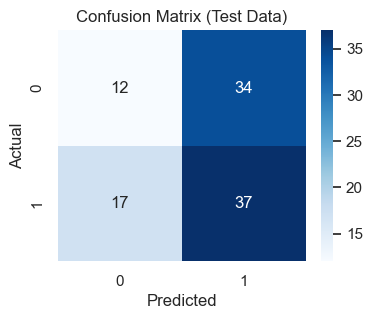

In [150]:
y_pred = final_pipeline.predict(X_test)

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (Test Data)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### 💾 Step 9: Save the Entire Pipeline


In [151]:
joblib.dump(final_pipeline, "final_model_pipeline.pkl")
print("💾 Saved the entire preprocessing + model pipeline to disk.")

💾 Saved the entire preprocessing + model pipeline to disk.


### 🧩 Step 10: Load and Predict on a New Row (Production Simulation)

In [152]:
# Load pipeline
loaded_pipeline = joblib.load("final_model_pipeline.pkl")

# Example new data (can contain missing values or unseen categories)
new_data = pd.DataFrame(
    {
        "age": [33],
        "salary": [60000],
        "experience_years": [5],
        "education_level": ["master"],
        "city": ["Bangalore"],
        "owns_car": ["yes"],
    }
)

# Predict
new_pred = loaded_pipeline.predict(new_data)
print("Predicted Class:", new_pred)

Predicted Class: [1]
